In [203]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
import c2qa.util as util
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector


A notebook to try and implement Algorithm 1 in appendix F of https://arxiv.org/pdf/2407.10381 , and then costing it in fault-tolerant manner.

In [204]:
#setup registers
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode = 1)


#convenient labeling
qumode = qmr[0]

#The circuit is initalized to |0> by default
circuit = c2qa.CVCircuit(qmr)

circuit.initialize(1, qmr[0])
#put the qubit into a superposition and then execute a controlled displacement of the cavity
alpha = -1j
circuit.cv_d(alpha, qmr[0])


#simulate and plot
statev, _, _ = c2qa.util.simulate(circuit)

print(statev)

Statevector([0.        -0.84147098j, 0.54030231+0.j        ],
            dims=(2,))


In [205]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.quantum_info import Statevector
from qiskit import transpile, QuantumCircuit

# Define the variables
alpha = 1
beta = 0
gamma = 0
kappa = 0
t = 1  # Argument for the Rx gate
j = 1
# Create a quantum circuit with 1 qubit
qc = QuantumCircuit(3)

# Initialize the state |psi> = |01> (alpha|0> + beta|1>) + |11>(gamma|0> + kappa|1>)
initial_state = [0, 0, alpha, beta, 0, 0, gamma, kappa]
qc.initialize(initial_state, [0,1,2])

#we have to somehow index the gate, maybe it does need to be 
# |1><1| \otimes Rx(2t) ... and they're both getting applied to the qubit 0!
qc.rx(2*t, 1)
qc.rx(2*t*np.sqrt(3), 2)

from qiskit.quantum_info import Statevector
statevector = Statevector(qc)

print(statevector)
print(np.cos(j), np.sin(j))
print(np.sin(np.sqrt(3)), np.cos(np.sqrt(3)))

Statevector([ 0.        +0.13510367j,  0.        +0.j        ,
             -0.08674907+0.j        ,  0.        +0.j        ,
             -0.83055428+0.j        ,  0.        +0.j        ,
              0.        -0.53329277j,  0.        +0.j        ],
            dims=(2, 2, 2))
0.5403023058681398 0.8414709848078965
0.9870266449903538 -0.16055653857469052


If $(\sqrt{x})_j$ represents the value of the $j$-th bit in the fixed-point representation of the square root in increasing order of significance, then:

$$
e^{-i\sqrt{x}\sigma_x t} = H e^{-i\sqrt{x}\sigma_z t} H = H \prod_{j=0}^{n-1} e^{-i (\sqrt{x})_j 2^j \sigma_z t} H.
$$


### Pure trotterization method

In [206]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2

import sys
from pathlib import Path

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
sys.path.append(str(playground_path))
# Homemade functions
from bosonic_operator_costs.all_qubit_utils import create_annihilation_operator, create_creation_operator, convert_hamiltonian_to_pauli_string, evolve_system

In [207]:
def displacement_hamiltonian(n_max, alpha=1):
    """
    Creates the matrix representation of the operator i*alpha(b^dagger - b).

    Parameters:
        n_max (int): The Fock cutoff.
        alpha (complex, optional): The amount of displacement. Defaults to 1.

    Returns:
        np.ndarray: The matrix representation of i*alpha(b^dagger - b).
    """
    b = create_annihilation_operator(n_max)
    b_dag = create_creation_operator(n_max)

    hamiltonian = 1j* (alpha * b_dag - alpha.conjugate() * b)
    return hamiltonian


def define_initial_state(num_modes, n_max):
    """
    Define the initial state vector for the system.

    Parameters:
        n_qubits (int): The number of qubits in the system.

    Returns:
        Statevector: The initial quantum state.
    """
    n_qubits = num_modes * int(np.ceil(np.log2(n_max + 1)))
    initial_state_vector = np.zeros(2**n_qubits, dtype=complex)
    initial_state_vector[0] = 1.0

    return Statevector(initial_state_vector)

In [ ]:
from qiskit.quantum_info import Statevector

num_qubits_per_mode = 4
n_max = 2**num_qubits_per_mode - 1
num_modes = 1
alpha = 1
initial_state = define_initial_state(num_modes, n_max)

hamiltonian = displacement_hamiltonian(n_max, alpha)


hamiltonian = SparsePauliOp.from_operator(Operator(hamiltonian))

# print(hamiltonian)
# print(1j*hamiltonian.to_matrix())


[[ 0.00000000e+00+0.j  1.00000000e+00+0.j  0.00000000e+00+0.j
  -1.11022302e-16+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-1.00000000e+00+0.j  0.00000000e+00+0.j  1.41421356e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  -1.11022302e-16+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -1.41421356e+00+0.j  0.00000000e+00+0.j
   1.73205081e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 

In [ ]:
problem = TimeEvolutionProblem(hamiltonian, initial_state=initial_state, time=0.001)
trotter = TrotterQRTE()
circuit = trotter.evolve(problem).evolved_state

backend=GenericBackendV2(2)

transpiled_circuit = transpile(
    circuit,
    basis_gates=backend.operation_names,
    optimization_level=1
)


statevector = Statevector(circuit)
unitary = Operator(circuit)
print(statevector)
# print(unitary)

Statevector([-3.27930969e-01+0.j,  6.31114284e-01+0.j, -6.88500773e-01+0.j,
             -6.52352283e-02+0.j,  1.24836928e-01+0.j,  1.53809822e-02+0.j,
              6.73518253e-03+0.j, -9.45174667e-04+0.j, -2.20066091e-05+0.j,
             -2.23874541e-05+0.j, -2.06320185e-05+0.j, -5.87378728e-07+0.j,
              8.30996827e-07+0.j, -1.31409490e-07+0.j,  1.17792656e-08+0.j,
              4.02381119e-10+0.j],
            dims=(2, 2, 2, 2))


In [ ]:
#setup registers
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode = num_qubits_per_mode)

#convenient labeling
qumode = qmr[0]

#The circuit is initalized to |0> by default
circuit = c2qa.CVCircuit(qmr)

#put the qubit into a superposition and then execute a controlled displacement of the cavity
alpha = 0.001
circuit.cv_d(alpha, qmr[0])


#simulate and plot
statev, _, _ = c2qa.util.simulate(circuit)

unitary = Operator(circuit)
# print(unitary)
print(statev)

Statevector([6.06530660e-01+0.j, 6.06530660e-01+0.j, 4.28881942e-01+0.j,
             2.47615105e-01+0.j, 1.23807552e-01+0.j, 5.53684207e-02+0.j,
             2.26040631e-02+0.j, 8.54353279e-03+0.j, 3.02059499e-03+0.j,
             1.00686500e-03+0.j, 3.18398662e-04+0.j, 9.60008527e-05+0.j,
             2.77127962e-05+0.j, 7.68758496e-06+0.j, 2.04737718e-06+0.j,
             5.61860029e-07+0.j],
            dims=(2, 2, 2, 2))


planned next steps:
plot the wigner function and comapre these two states!


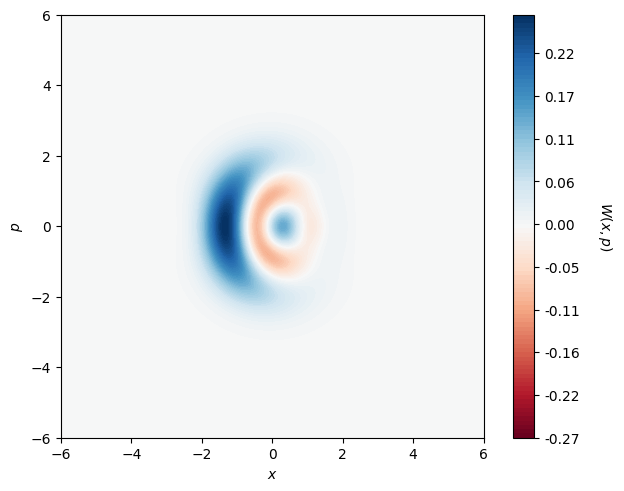

In [241]:
qmr0 = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_mode)
circuit0 = c2qa.CVCircuit(qmr0)



circuit0.cv_initialize([-3.27930969e-01+0.j,  6.31114284e-01+0.j, -6.88500773e-01+0.j,
             -6.52352283e-02+0.j,  1.24836928e-01+0.j,  1.53809822e-02+0.j,
              6.73518253e-03+0.j, -9.45174667e-04+0.j, -2.20066091e-05+0.j,
             -2.23874541e-05+0.j, -2.06320185e-05+0.j, -5.87378728e-07+0.j,
              8.30996827e-07+0.j, -1.31409490e-07+0.j,  1.17792656e-08+0.j,
              4.02381119e-10+0.j], qmr0[0])

# # Initialize the qumode to a zero Fock sate
# circuit0.cv_initialize([6.06530660e-01+0.j, 6.06530660e-01+0.j, 4.28881942e-01+0.j,
#              2.47615105e-01+0.j, 1.23807552e-01+0.j, 5.53684207e-02+0.j,
#              2.26040631e-02+0.j, 8.54353279e-03+0.j, 3.02059499e-03+0.j,
#              1.00686500e-03+0.j, 3.18398662e-04+0.j, 9.60008527e-05+0.j,
#              2.77127962e-05+0.j, 7.68758496e-06+0.j, 2.04737718e-06+0.j,
#              5.61860029e-07+0.j], qmr0[0])

# circuit0.cv_d(alpha, qmr0[0])


state0, _, _ = c2qa.util.simulate(circuit0)

c2qa.wigner.plot_wigner(circuit0, state0)
